# SPLEX TME9 - Bayesian Networks for Clinical Data Analysis
Jérémie Perrin & Witold PODLEJSKI

___0. Importing libraries___

In [1]:
import pandas as pd
import numpy as np
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn
from IPython.display import Image

___1. Creating a network using PyAgrum___

First adding the nodes.

In [2]:
v = {'G':gum.LabelizedVariable('Glycemia'),'I':gum.LabelizedVariable('Insulin'),\
             'O':gum.LabelizedVariable('Other_drugs'),'R':gum.LabelizedVariable('Remission')}
vID = {'G':0,'I':0,'O':0,'R':0}
BN = gum.BayesNet()
for key,val in v.items():
    vID[key] = BN.add(val)
print(BN)

BN{nodes: 4, arcs: 0, domainSize: 16, dim: 8}


Now adding the arcs and the conditionnal probabilities.

In [3]:
BN.addArc(vID['G'],vID['I'])
BN.addArc(vID['G'],vID['O'])
BN.addArc(vID['I'],vID['R'])
BN.addArc(vID['O'],vID['R'])

In [4]:
p=gum.Potential().add(BN.variable(vID['G'])).fillWith([0.5,0.5])
q1=gum.Potential().add(BN.variable(vID['I'])).add(BN.variable(vID['G'])).fillWith([0.9,0.1,0.1,0.9])
q2=gum.Potential().add(BN.variable(vID['O'])).add(BN.variable(vID['G'])).fillWith([0.7,0.3,0.25,0.75])
r=gum.Potential().add(BN.variable(vID['R'])).add(BN.variable(vID['I'])).add(BN.variable(vID['O'])).fillWith([0.1,0.9,0.7,0.3,0.4,0.6,0.9,0.1])

In [5]:
BN.changePotential(vID['G'],p)
BN.changePotential(vID['I'],q1)
BN.changePotential(vID['O'],q2)
BN.changePotential(vID['R'],r)

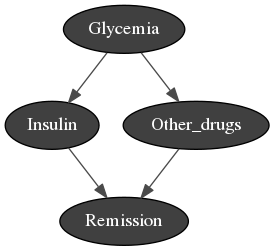

In [6]:
g = bnPlot.BN2dot(BN)
Image(g.create_png())

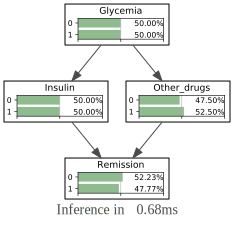

(gum::Potential<double>@0x55854f01db60) <Glycemia:0> :: 0.5 /<Glycemia:1> :: 0.5

In [11]:
gnb.showInference(BN,evs={})
BN.cpt(vID['G'])

Computing probabilities of remission when no drugs are taken.

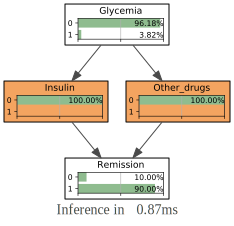

In [19]:
gnb.showInference(BN,evs={vID['O']:0,vID['I']:0})

Computing probabilities of remission if insulin prescribed and high glycemia

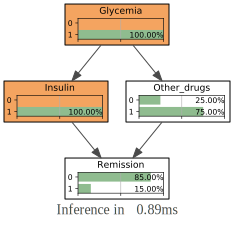

In [20]:
gnb.showInference(BN,evs={vID['G']:1,vID['I']:1})

___2. Construct Bayesian networks from real data___

Discretizing environment data

In [42]:
datae = pd.read_csv('data/SPLEX_env.txt', sep = " ")
l=[]
for col in datae.columns.values:
    bins = np.linspace(min(datae[col]), max(datae[col]), 5)
    l.append(pd.DataFrame(np.digitize(datae[col], bins),columns=[col]))
discr_datae=pd.concat(l, join='outer', axis=1)
discr_datae.to_csv("data/discr_data_env.csv",index=False)

Discretizing host data

In [43]:
datah = pd.read_csv('data/SPLEX_host.txt', sep = " ")
l=[]
for col in datah.columns.values:
    bins = np.linspace(min(datah[col]), max(datah[col]), 5)
    l.append(pd.DataFrame(np.digitize(datah[col], bins),columns=[col]))
discr_datah=pd.concat(l, join='outer', axis=1)
discr_datah.to_csv("data/discr_data_host.csv",index=False)

Concatenating both

In [70]:
discr_datab = pd.concat([discr_datae.reset_index(drop=True),discr_datah.reset_index(drop=True)], axis=1)
discr_datab.to_csv("data/discr_data_both.csv",index=False)

#### Learning the Networks
For the environment variables only.

In [65]:
learner=gum.BNLearner("data/discr_data_env.csv")
learner.useLocalSearchWithTabuList()
bn=learner.learnBN()
bnPlot.forDarkTheme()
bnPlot.pdfize(bn,"env_local")

learner.useGreedyHillClimbing()
bn=learner.learnBN()
bnPlot.forDarkTheme()
bnPlot.pdfize(bn,"env_greedy")

For the host variables only.

In [67]:
learner=gum.BNLearner("data/discr_data_host.csv")
learner.useLocalSearchWithTabuList()
bn1=learner.learnBN()
bnPlot.forDarkTheme()
bnPlot.pdfize(bn1,"host_local")

learner.useGreedyHillClimbing()
bn2=learner.learnBN()
bnPlot.forDarkTheme()
bnPlot.pdfize(bn2,"host_greedy")

gnb.sideBySide(bn1,bn2)

For both host and environment variables.

In [71]:
learner=gum.BNLearner("data/discr_data_both.csv")
learner.useLocalSearchWithTabuList()
bn1=learner.learnBN()
bnPlot.forDarkTheme()
bnPlot.pdfize(bn1,"both_local")

learner.useGreedyHillClimbing()
bn2=learner.learnBN()
bnPlot.forDarkTheme()
bnPlot.pdfize(bn2,"both_greedy")

gnb.sideBySide(bn1,bn2)

The networks are not the same although the set of variables connected are similar.

___3. Dynamic Bayesian Networks___

In [74]:
data = pd.read_csv('data/dynamic.txt', sep = " ")
l=[]
for col in data.columns.values:
    bins = np.linspace(min(data[col]), max(data[col]), 5)
    l.append(pd.DataFrame(np.digitize(data[col], bins),columns=[col]))
discr_data=pd.concat(l, join='outer', axis=1)
discr_data.to_csv("data/discr_data_dyn.csv",index=False)

learner=gum.BNLearner("data/discr_data_dyn.csv")
learner.useLocalSearchWithTabuList()
bn_dynamic=learner.learnBN()

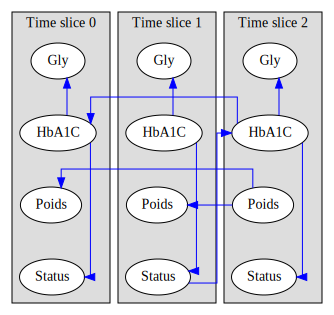

In [76]:
gdyn.showTimeSlices(bn_dynamic)

